In [345]:
### Regular Dropout

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd

import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [346]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())


# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

Inspired from: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut2_student_with_answers.html

In [347]:
def get_simple_data_train():
    x = torch.linspace(-2, 4, 300)
    x = torch.hstack([x, torch.linspace(6, 8, 300)])
    f = lambda x: torch.sin(x)
    eps = torch.randn_like(x) * 0.1
    f_x = f(x) 
    y_train = f_x + eps
    x_train = x[:, None]
    return x_train, y_train, f

In [348]:
def plot_generic(add_to_plot=None):
    fig, ax = plt.subplots()

    plt.xlabel("X",)
    plt.ylabel("Y",)

    x_train, y_train, true_func = get_simple_data_train()
    
    x_all = torch.linspace(-2, 8, 1000)

    ax.plot(x_train, y_train, 'C0', marker='o', ms= 4, linestyle='none', alpha=0.2, label='Observations')
    ax.plot(x_all, true_func(x_all), 'C1', linewidth=1, label="true function")
    if add_to_plot is not None:
        add_to_plot(ax)

    plt.legend(loc=4, frameon=False)
    plt.show()

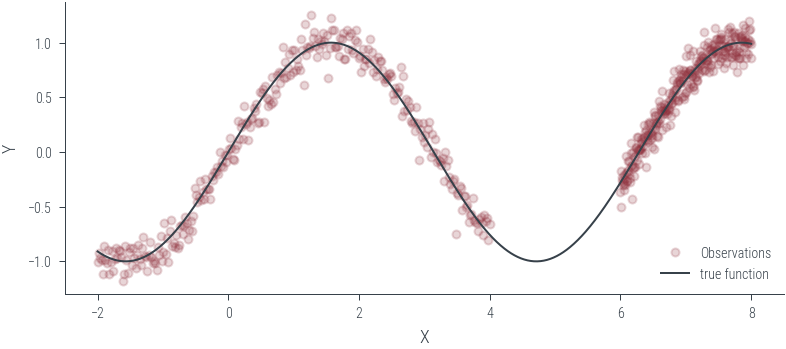

In [349]:
plot_generic()

In [350]:
# Define a simple MLP without using nn.Linear

input_dim = 1

hidden_l1_dim = 10
hidden_l2_dim = 5

W1 = torch.randn(input_dim, hidden_l1_dim).requires_grad_()
b1 = torch.zeros(hidden_l1_dim).requires_grad_()

W2 = torch.randn(hidden_l1_dim, hidden_l2_dim).requires_grad_()
b2 = torch.zeros(hidden_l2_dim).requires_grad_()

W3 = torch.randn(hidden_l2_dim, 1).requires_grad_()
b3 = torch.zeros(1).requires_grad_()

# Set device to GPU for all parameters
W1 = W1.to(device)
b1 = b1.to(device)
W2 = W2.to(device)
b2 = b2.to(device)
W3 = W3.to(device)
b3 = b3.to(device)


def mlp(x, params):
    W1, b1, W2, b2, W3, b3 = params
    h1 = torch.relu(x @ W1 + b1)
    h2 = torch.relu(h1 @ W2 + b2)
    return (h2 @ W3 + b3).ravel()

In [353]:
train_x, train_y, true_func = get_simple_data_train()
train_x = train_x.to(device)
train_y = train_y.to(device)


In [354]:
train_x.shape

torch.Size([600, 1])

In [355]:
test_x = torch.linspace(-2, 8, 1000)[:, None]
test_x = test_x.to(device)

In [356]:
parameters = [W1, b1, W2, b2, W3, b3]
# Scale each parameter by 0.1
#parameters = [p * 0.1 for p in parameters]

In [359]:
y_hat_untrained = mlp(test_x, parameters).ravel()
# Detach and convert to numpy
y_hat_untrained = y_hat_untrained.cpu().detach().numpy()

In [360]:
def plot_predictions(x_test, y_preds):
    def add_predictions(ax):
        ax.plot(x_test, y_preds, 'C2', label='neural net prediction')

    plot_generic(add_predictions)


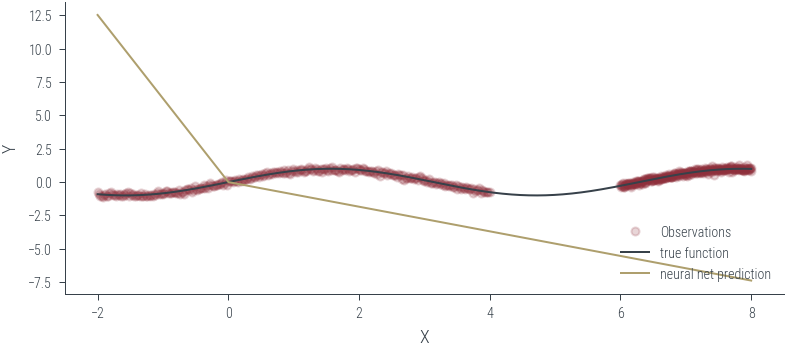

In [362]:
# Plot the untrained model
plot_predictions(test_x.cpu(), y_hat_untrained)

In [363]:
def train(params, opt, fwd_func, x_train, y_train, epochs=1000):
    for i in range(epochs):
        y_hat = fwd_func(x_train, params)
        loss = F.mse_loss(y_hat, y_train)
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if i % 200 == 0:
            print(f"Epoch {i}, loss {loss.item():.3f}")
    return params
        

In [364]:
# Train the model
optimizer = torch.optim.Adam(parameters, lr=3e-4)

trained_params = train(parameters, optimizer, mlp, train_x, train_y, epochs=5000)

ValueError: can't optimize a non-leaf Tensor

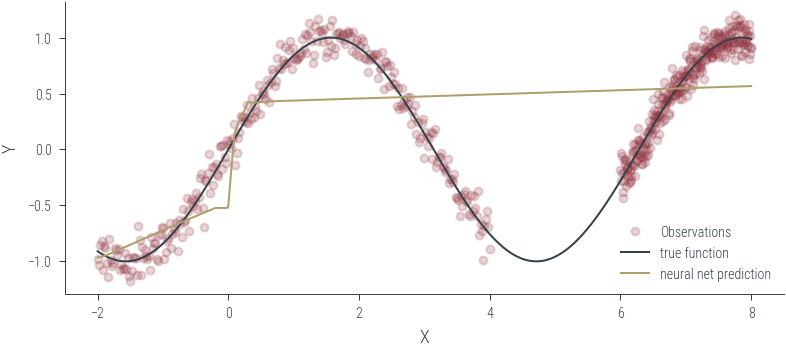

In [344]:
# Plot the trained model
y_hat_trained = mlp(test_x, trained_params).ravel()
# Detach and convert to numpy
y_hat_trained = y_hat_trained.detach().numpy()

plot_predictions(test_x, y_hat_trained)

In [229]:
### Now adding dropout to the model by manually masking the activations

h1 = torch.relu(test_x @ W1 + b1)
h1.shape



torch.Size([1000, 10])

In [230]:
# probability of dropping out each neuron
p = 0.2

In [231]:
mask = torch.rand_like(h1) > p
mask.shape

torch.Size([1000, 10])

In [232]:
h1.shape

torch.Size([1000, 10])

In [233]:
mask.sum()

tensor(7943)

In [234]:
mask.numel()

10000

In [235]:
masked_activations = h1 * mask
masked_activations.shape

torch.Size([1000, 10])

In [236]:
pd.DataFrame(masked_activations.detach().numpy()).head()

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,1.442507,0.0,2.298010,4.438922,0.0,0.0,3.105566
1,0.0,0.0,0.0,0.000000,0.0,2.294840,0.000000,0.0,0.0,3.100784
2,0.0,0.0,0.0,1.444633,0.0,2.291669,4.409437,0.0,0.0,3.096001
3,0.0,0.0,0.0,0.000000,0.0,2.288498,4.394694,0.0,0.0,3.091219
4,0.0,0.0,0.0,1.446760,0.0,2.285327,0.000000,0.0,0.0,3.086437


In [237]:
pd.DataFrame(h1.detach().numpy()).head()

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,1.442507,0.0,2.298010,4.438922,0.0,0.0,3.105566
1,0.0,0.0,0.0,1.443570,0.0,2.294840,4.424180,0.0,0.0,3.100784
2,0.0,0.0,0.0,1.444633,0.0,2.291669,4.409437,0.0,0.0,3.096001
3,0.0,0.0,0.0,1.445697,0.0,2.288498,4.394694,0.0,0.0,3.091219
4,0.0,0.0,0.0,1.446760,0.0,2.285327,4.379951,0.0,0.0,3.086437


In [238]:
pd.DataFrame(mask.detach().numpy()).head()

,0,1,2,3,4,5,6,7,8,9
0,True,True,True,True,True,True,True,True,True,True
1,True,True,False,False,True,True,False,False,True,True
2,False,True,True,True,True,True,True,True,True,True
3,True,True,True,False,True,True,True,True,True,True
4,False,True,False,True,True,True,False,True,False,True


In [141]:
### Rewriting the model with dropout

def mlp_dropout(x, training=True):
    h1 = torch.relu(x @ W1 + b1)
    if training:
        # probability of dropping out each neuron
        mask = torch.rand_like(h1) > p
        h1 = h1 * mask
        # scale activations to account for dropout
        #h1 = h1 / (1 - p)
    return h1 @ W2 + b2

In [142]:
# Train the model
p = 0.1
parameters = [W1, b1, W2, b2]
optimizer = torch.optim.Adam(parameters, lr=3e-4)

for i in range(5000):
    y_hat = mlp_dropout(x.unsqueeze(1), True).ravel()
    loss = F.mse_loss(y_hat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        print(f'Iteration {i}, loss {loss.item():.2f}')

Iteration 0, loss 0.18
Iteration 100, loss 0.19
Iteration 200, loss 0.23
Iteration 300, loss 0.24
Iteration 400, loss 0.23
Iteration 500, loss 0.17
Iteration 600, loss 0.17
Iteration 700, loss 0.22
Iteration 800, loss 0.18
Iteration 900, loss 0.22
Iteration 1000, loss 0.20
Iteration 1100, loss 0.23
Iteration 1200, loss 0.20
Iteration 1300, loss 0.19
Iteration 1400, loss 0.22
Iteration 1500, loss 0.21
Iteration 1600, loss 0.19
Iteration 1700, loss 0.18
Iteration 1800, loss 0.16
Iteration 1900, loss 0.17
Iteration 2000, loss 0.20
Iteration 2100, loss 0.19
Iteration 2200, loss 0.29
Iteration 2300, loss 0.21
Iteration 2400, loss 0.21
Iteration 2500, loss 0.18
Iteration 2600, loss 0.21
Iteration 2700, loss 0.23
Iteration 2800, loss 0.22
Iteration 2900, loss 0.18
Iteration 3000, loss 0.23
Iteration 3100, loss 0.19
Iteration 3200, loss 0.19
Iteration 3300, loss 0.19
Iteration 3400, loss 0.19
Iteration 3500, loss 0.19
Iteration 3600, loss 0.21
Iteration 3700, loss 0.25
Iteration 3800, loss 0.2

Text(0, 0.5, '$y$')

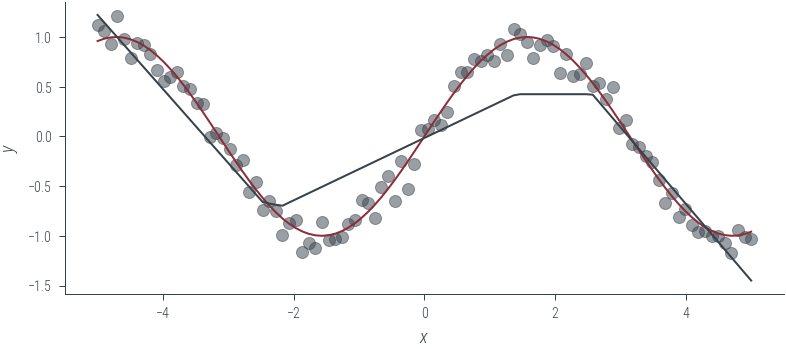

In [143]:
# Predictions with dropout
y_hat_dropout = mlp_dropout(x.unsqueeze(1), False).ravel()

# Plot the trained model
plt.plot(x, f(x), label='True function')
plt.scatter(x, y, label='Noisy data', color='C1', alpha=0.5)
plt.plot(x, y_hat_dropout.detach(), label='Trained model with dropout')
plt.xlabel('$x$')
plt.ylabel('$y$')

In [144]:
preds = [mlp_dropout(x.unsqueeze(1), True).ravel() for _ in range(5)]


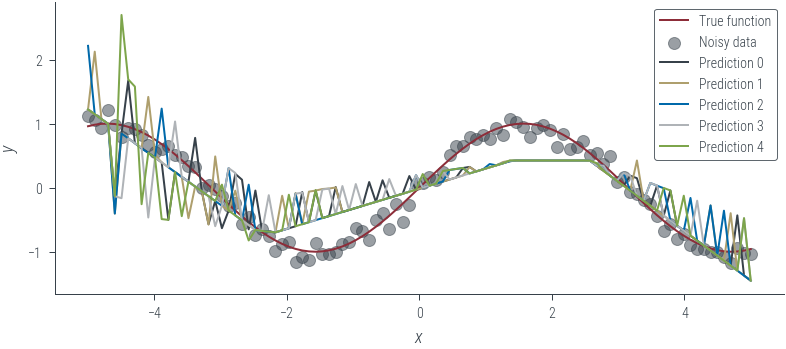

In [145]:
# Plot MC dropout predictions

plt.plot(x, f(x), label='True function')
plt.scatter(x, y, label='Noisy data', color='C1', alpha=0.5)
for i, y_hat in enumerate(preds):
    plt.plot(x, y_hat.detach(), label=f'Prediction {i}')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()

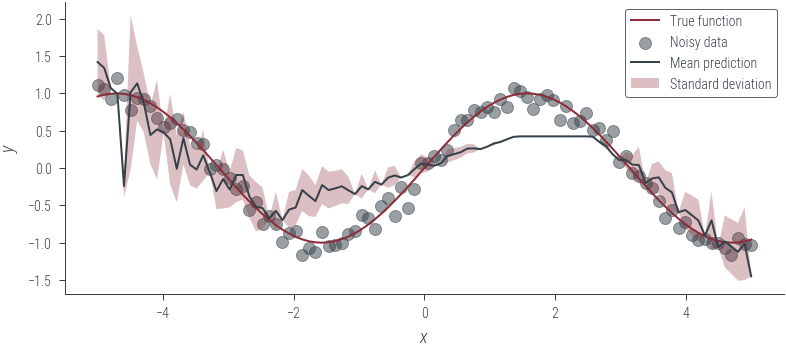

In [146]:
# Plot mean and variance of MC dropout predictions

means = torch.stack(preds).mean(0)
stds = torch.stack(preds).std(0)

plt.plot(x, f(x), label='True function')
plt.scatter(x, y, label='Noisy data', color='C1', alpha=0.5)
plt.plot(x, means.detach(), label='Mean prediction')
plt.fill_between(x, (means - stds).detach(), (means + stds).detach(), alpha=0.3, label='Standard deviation')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
